<a href="https://colab.research.google.com/github/PapaCosta/Data-Analysis-Portfolio/blob/main/Time_in_the_Market_how_long_is_long_enough%3F.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Time in the market - but how long is long enough?**

Initially I wanted to try this analysis with `ETFs` since these are one of the main financial assets used right now to invest. The problem is that they are relatively new compared to their index, not covering some of the major market crashes such as the dot-com bubble and the financial crysis in 2008. Hence, using the indexes for the analysis of those assets.


## **Tasks**


*   Plot price charts
*   Unfold and transform data
*   Plot ROI comparing it with the time in the market
*   Turn ROI into annual return and take into account inflation
*   Historically what were the dates that yielded the best and worst returns
*   Compare between assets the breakeven duration (violin plot) and estimated annual return



---



## **Data**

### Potential assets for analysis:
For this analysis, I'm going to consider some of the most mature and favorite assets. The scope is if the average investor that is starting investing is going to be profitable (given enough time in the market) and, naturally, this investor is going to be on the non-leveraged safer assets. Experienced investors on the other hand might prefer other riskier investments. I think I'm pushing it a bit with Gold, but nevertheless wanted to see what kind of results we would get. 


*   **ETF** - [iShares Core S&P 500 UCITS ETF USD (Acc) (CSSPX)](https://www.investing.com/etfs/cs-etf-(ie)-on-s-p-500?cid=46891)
*   **ETF** - [iShares Core MSCI World UCITS ETF USD (Acc) (IWDA)](https://www.investing.com/etfs/ishares-msci-world---acc?cid=47285)
*   **Stock** - [Microsoft (MSFT)](https://www.investing.com/equities/microsoft-corp?cid=29399)
*   **Cryptocurrency** - [Bitcoin (BTC)](https://www.investing.com/crypto/bitcoin?cid=1057388)
*   **Commodity** - [Gold](https://www.investing.com/etfs/xetra-gold)

All data taken from an european exchange (EUR as currency). The data was exported grouped weekly. Daily price action would be more important for trading rather than investing. For the latter, a weekly period is more relevant.




---


## **Libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



---


## **Importing and cleaning data**

First step is importing the data and clean it. There are somethings to be done before we can use this data for our analysis.

After looking through the data, data types and formats, this is our to-do list:

**Convert 1,000.00 format to 1000.00**

>*- This happens in the Bitcoin table where price gets to the thousands and it's not possible to convert the current format (e.g. 1,000.00) into float, so we can't use it this way for any kind of operations.*

**Transform `Date` data type into datetime**

>*- We have to convert data type from object into datetime.*

**Remove % sign in `Change %` and convert type to float**

>*- We need to remove the % sign in order to be able to convert this column into a float.*

**Replace 1M, 1K into 1e6 and 1e3, and also - to 0 in `Vol.`**

>*- We have to convert the current format to a numeric form in order to be able to use it in operations.*

**Convert `Asset` data type into string**

>*- After concatenating all the tables into a single one, this column get a date type of object. We have to convert it to string.*

In [2]:
#Import S&P500 data
df_sp = pd.read_csv("sp500_data.csv")
df_sp['Asset']='S&P500'

#Import MSCI World data
df_world = pd.read_csv("world_data.csv")
df_world['Asset']='World'

#Import Microsoft data
df_msft = pd.read_csv("msft_data.csv")
df_msft['Asset']='MSFT'

#Import Bitcoin data
df_btc = pd.read_csv("bitcoin_data.csv")
df_btc['Asset']='Bitcoin'
df_btc['Price'] = df_btc['Price'].str.replace(',', '').astype('float')
df_btc['Open'] = df_btc['Open'].str.replace(',', '').astype('float')
df_btc['High'] = df_btc['High'].str.replace(',', '').astype('float')
df_btc['Low'] = df_btc['Low'].str.replace(',', '').astype('float')

#Import Gold data
df_gold = pd.read_csv("gold_data.csv")
df_gold['Asset']='Gold'

list_assets = ['S&P500', 'World', 'MSFT', 'Bitcoin', 'Gold']

#Combine dataframes
df_main=pd.concat([df_sp, df_world, df_msft, df_btc, df_gold], keys=list_assets)
df_main['Date'] = pd.to_datetime(df_main['Date'])
df_main['Change %'] = df_main['Change %'].str.replace('%', '').astype('float')
df_main['Asset'] = df_main['Asset'].astype('string')
df_main['Vol.'] = df_main['Vol.'].replace({'K': '*1e3', 'M': '*1e6', 'B': '*1e9', '-': 0}, regex=True).map(pd.eval).astype(int)

df_main.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3201 entries, ('S&P500', 0) to ('Gold', 734)
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      3201 non-null   datetime64[ns]
 1   Price     3201 non-null   float64       
 2   Open      3201 non-null   float64       
 3   High      3201 non-null   float64       
 4   Low       3201 non-null   float64       
 5   Vol.      3201 non-null   int64         
 6   Change %  3201 non-null   float64       
 7   Asset     3201 non-null   string        
dtypes: datetime64[ns](1), float64(5), int64(1), string(1)
memory usage: 231.4+ KB


In [3]:
df_main.isnull().sum()

Date        0
Price       0
Open        0
High        0
Low         0
Vol.        0
Change %    0
Asset       0
dtype: int64

In [4]:
df_main.head()

Date  Price   Open   High    Low  Vol.  Change %   Asset
S&P500 0 2010-05-30  76.47  75.76  77.44  75.49   260      1.49  S&P500
       1 2010-06-06  76.24  75.11  75.11  74.81   130     -0.30  S&P500
       2 2010-06-13  76.88  76.39  76.66  76.34   330      0.84  S&P500
       3 2010-06-20  73.77  74.92  74.92  74.05    50     -4.05  S&P500
       4 2010-06-27  68.95  73.08  73.08  69.81    20     -6.53  S&P500

As seen, we get a master table with all the assets data put together with the correct data types and no null values.

With this we can plot for each assets the price action and check if they are ploted correctly.

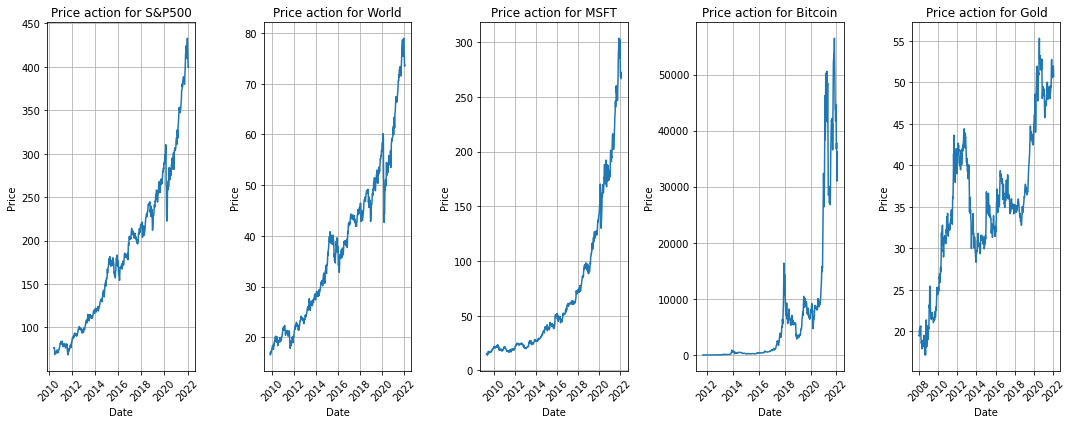

In [5]:
fig, ax = plt.subplots(1,5,figsize=(15,6))

for i, asset in zip(range(0,5), list_assets):
  ax[i].plot(df_main['Date'][asset], df_main['Price'][asset])
  ax[i].set(xlabel='Date', ylabel='Price', title='Price action for ' + str(asset))
  ax[i].tick_params('x', labelrotation=45)
  ax[i].grid()

plt.tight_layout()
plt.show()



---

## **Transform Data**

Next step is to transform the weekly prices in order to know what would be the return if the asset were to be hold for x weeks. This would simulate a lot of different timed investments with different holding duration and would make possible to know where would you get negative returns in the past 10 years if you were to invest in any of these assets and, better yet, how long you were negative in the worst cases.

We want to get an end result like this one:

| Asset | Date | Duration (in weeks) | ROI |
| :- | :- | -: | :-: |
| Asset1 | Date1 | 1 | 1
| Asset1 | Date1 | 2 | 0.8
| Asset1 | Date2 | 1 | -0.6
| Asset1 | Date2 | 2 | 0.2
| Asset2 | Date1 | 1 | 0.5

The way to interpret this table is: 
>An 100€ buy of the **Asset1** on the **Date1** would get you a return of **1%** (101€) in the first week and **0.8%** (100.8€) in the second week.

>On the other hand, the same 100€ buy of the **Asset1** on the **Date2**, would get you **-0.6%** (99.4€) in the first week and **0.2%** (100.2€) in the second.


In order to get a table like this one, we have to loop the main table through the different assets, through each date and calculate the duration and the change percent wise of the return of investment.

Although we have the `Change %` column which tell us how much the price has changed percent wise during that week, we can't use it for periods of more than 1 week. Why is that?

This is something that can easily be confused, but if we think of an example, it will be clear.

Looking at the first 10 weeks of the S&P500, we could say that we just have to add the values in `Change %` for this period of 9 weeks (We don't include the first week, since that is when we bought). But this is not true. The true return of investment is given by: 

$$
ROI = (\frac{FinalPrice}{InitialPrice}-1)*100
$$

For this example, in a period of 9 weeks, the diference is of around 0.2, which for some cases can be the diference between a positive and a negative return.


In [6]:
df_main.loc['S&P500'].head(10)

,Date,Price,Open,High,Low,Vol.,Change %,Asset
0,2010-05-30,76.47,75.76,77.44,75.49,260,1.49,S&P500
1,2010-06-06,76.24,75.11,75.11,74.81,130,-0.30,S&P500
2,2010-06-13,76.88,76.39,76.66,76.34,330,0.84,S&P500
3,2010-06-20,73.77,74.92,74.92,74.05,50,-4.05,S&P500
4,2010-06-27,68.95,73.08,73.08,69.81,20,-6.53,S&P500
5,2010-07-04,72.05,68.86,72.27,68.86,5760,4.50,S&P500
6,2010-07-11,70.61,73.71,73.71,71.80,2850,-2.00,S&P500
7,2010-07-18,72.31,69.53,72.13,69.53,80,2.41,S&P500
8,2010-07-25,71.59,71.59,71.59,71.59,0,-1.00,S&P500
9,2010-08-01,71.02,72.63,73.23,72.00,930,-0.80,S&P500


In [7]:
#Sum all the values in Change % and subtract the first one
sumchange10 = df_main.loc['S&P500']['Change %'].head(10).sum()-df_main.loc['S&P500',0]['Change %']
#Applying the ROI formula
realchange10 = (df_main.loc['S&P500',9]['Price']/df_main.loc['S&P500',0]['Price']-1)*100

print('The sum of the Change % during the first 10 weeks equals to ' + str(sumchange10))
print('The real return of investment is ' + str(realchange10))

The sum of the Change % during the first 10 weeks equals to -6.930000000000001
The real return of investment is -7.126977899830001


Now let's create the new table that'll hold all the new transformed data. We'll loop through the assets and dates and calculate the ROI.

To make it a bit more efficient we can think on the formula to calculate ROI as seen before, take all the prices after the desired date and divide all those prices by the initial price to get the corresponding return of investments for each week. We just have to atribute the correct duration afterwards.

In [8]:
# Create new table
df_roi = pd.DataFrame(columns = ['Asset', 'Date', 'Duration','ROI'])

#Looping through assets
for asset in list_assets:
  # Looping through the dates and calculate duration and ROI for each
  for index, row in df_main.loc[asset].iterrows():
    #Divide prices by the initial price
    df = (df_main.loc[asset].iloc[index+1:, 1]/df_main.loc[asset].iloc[index, 1]-1)*100

    df2 = pd.DataFrame(
      {'Asset': ([row[7]] * len(df)),
      'Date':[row[0]] * len(df),
      'Duration': df.index.tolist(),
      'ROI': df
      })
    df2['Duration']=df2['Duration']-index
    df2['Asset']=df2['Asset'].astype('string')
    if len(df_roi)==0:
      df_roi=df2
    else:
      df_roi = df_roi.append(df2)

df_roi['Positive Return'] = df_roi['ROI']>0

df_roi.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1032937 entries, 1 to 734
Data columns (total 5 columns):
 #   Column           Non-Null Count    Dtype         
---  ------           --------------    -----         
 0   Asset            1032937 non-null  string        
 1   Date             1032937 non-null  datetime64[ns]
 2   Duration         1032937 non-null  float64       
 3   ROI              1032937 non-null  float64       
 4   Positive Return  1032937 non-null  bool          
dtypes: bool(1), datetime64[ns](1), float64(2), string(1)
memory usage: 40.4 MB


In the end, we get a table with 1 million rows, calculated in nearly over 1 min. We can look inside the table to see what it looks like and check if the ROI of 30/05/2010 with 9 week duration matches the one calculated before, which it does.

In [9]:
df_roi[(df_roi['Asset']=='S&P500')].head(9)

,Asset,Date,Duration,ROI,Positive Return
1,S&P500,2010-05-30,1.0,-0.300772,False
2,S&P500,2010-05-30,2.0,0.536158,True
3,S&P500,2010-05-30,3.0,-3.530796,False
4,S&P500,2010-05-30,4.0,-9.833922,False
5,S&P500,2010-05-30,5.0,-5.780044,False
6,S&P500,2010-05-30,6.0,-7.663136,False
7,S&P500,2010-05-30,7.0,-5.440042,False
8,S&P500,2010-05-30,8.0,-6.381588,False
9,S&P500,2010-05-30,9.0,-7.126978,False


We'll create as well a table for the risk of holding an asset for a given ammount of weeks. For this table, we group for each asset the duration and get the average of negative returns for each week.

In [10]:
risk_ratio = ((1-df_roi.groupby(by=['Asset', 'Duration'])['Positive Return'].mean())*100).to_frame()
risk_ratio.reset_index(inplace=True)
risk_ratio.rename(columns={'Positive Return':'Risk'}, inplace=True)

risk_ratio[risk_ratio['Asset']=='S&P500'].head()

,Asset,Duration,Risk
1946,S&P500,1.0,39.244663
1947,S&P500,2.0,35.690789
1948,S&P500,3.0,37.067545
1949,S&P500,4.0,35.643564
1950,S&P500,5.0,31.570248


So for the S&P500, holding the asset for 1 week, has a 39.2% risk of the return being negative. We'll plot it afterwards and check how it changes with the duration.



---


## **Analyse Data**

Now that we have all the desired information, we can start ploting and analyse the data to extract some conclusions. We'll start by looking at the ROI over the duration.

### **Return of Investment in different timeframes**



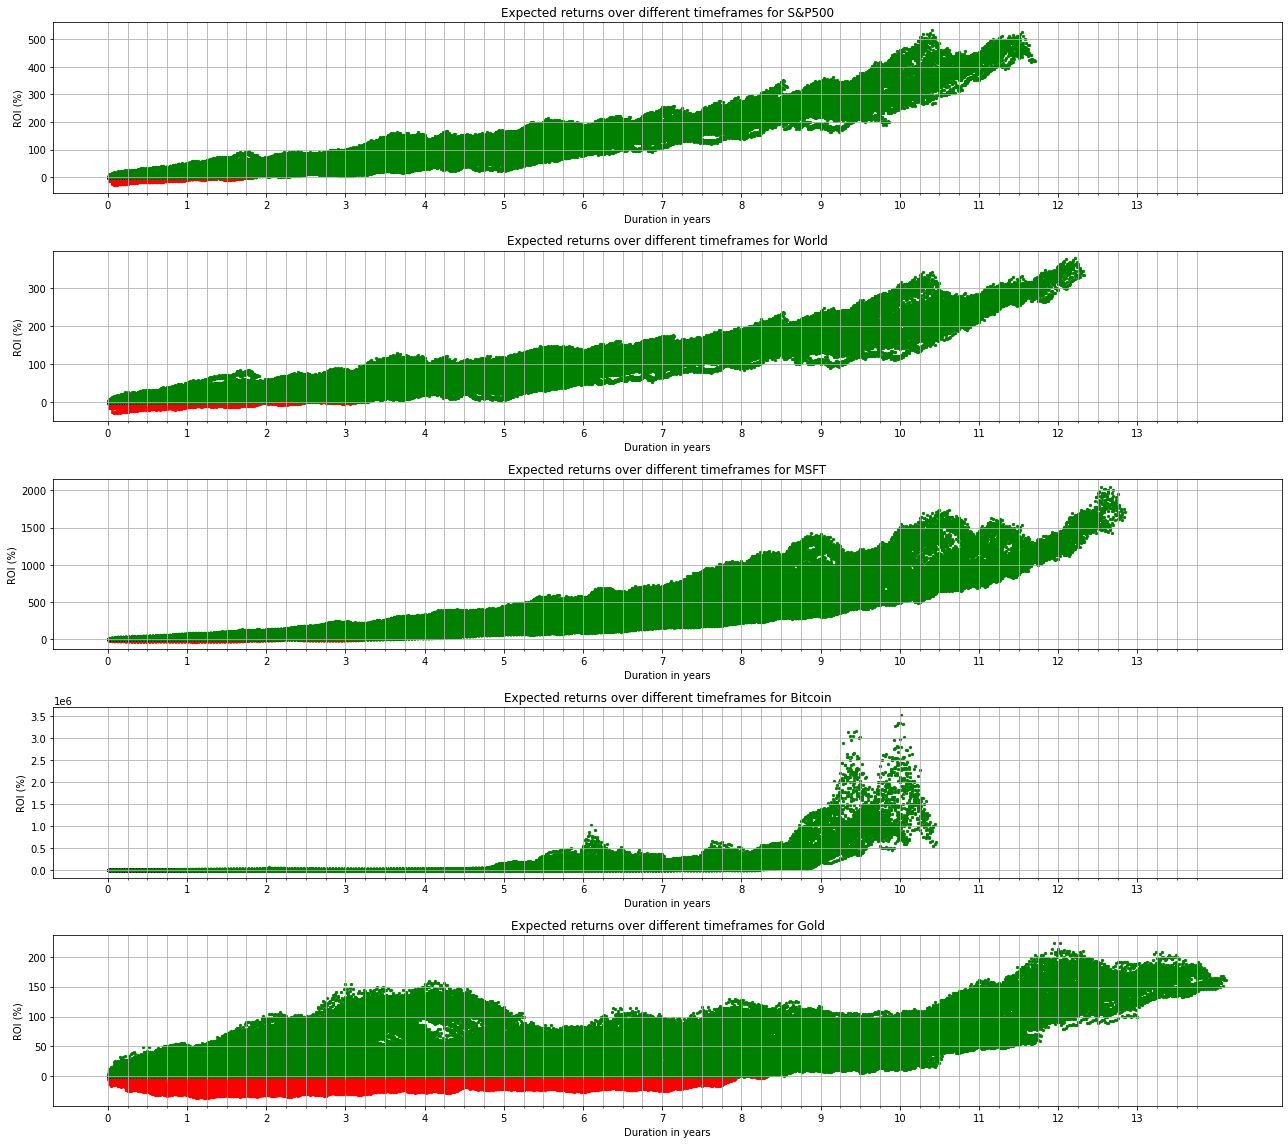

In [11]:
fig, ax = plt.subplots(5, 1, figsize=(18,16), tight_layout=True, sharex=True)

major_ticks = np.arange(0, 14, 1)
minor_ticks = np.arange(0, 14, 0.25)

for asset, i in zip(list_assets, range(0,5)):
  ax[i].scatter(df_roi['Duration'][(df_roi['ROI'] <= 0) & (df_roi['Asset']==asset)]/52, df_roi['ROI'][(df_roi['ROI'] <= 0) & (df_roi['Asset']==asset)], c="red", s=5)
  # plot points outside distribution's width
  ax[i].scatter(df_roi['Duration'][(df_roi['ROI'] > 0) & (df_roi['Asset']==asset)]/52, df_roi['ROI'][(df_roi['ROI'] > 0) & (df_roi['Asset']==asset)], c='green', s=5)

  ax[i].set(xlabel='Duration in years', ylabel='ROI (%)', title = 'Expected returns over different timeframes for ' + str(asset))

  ax[i].set_xticks(major_ticks)
  ax[i].set_xticks(minor_ticks, minor=True)
  ax[i].grid(which='both')
  ax[i].xaxis.set_tick_params(labelbottom=True)

plt.show()

On the 5 charts above we can see all the possible trades over different timeframes. Anything above 0 is positive return and everything below or equals to zero is negative. Considering zero as negative since the goal of investing is to get some kind of profit. On the next 5 charts, let's zoom in on the negative ones and trace the risk lines.

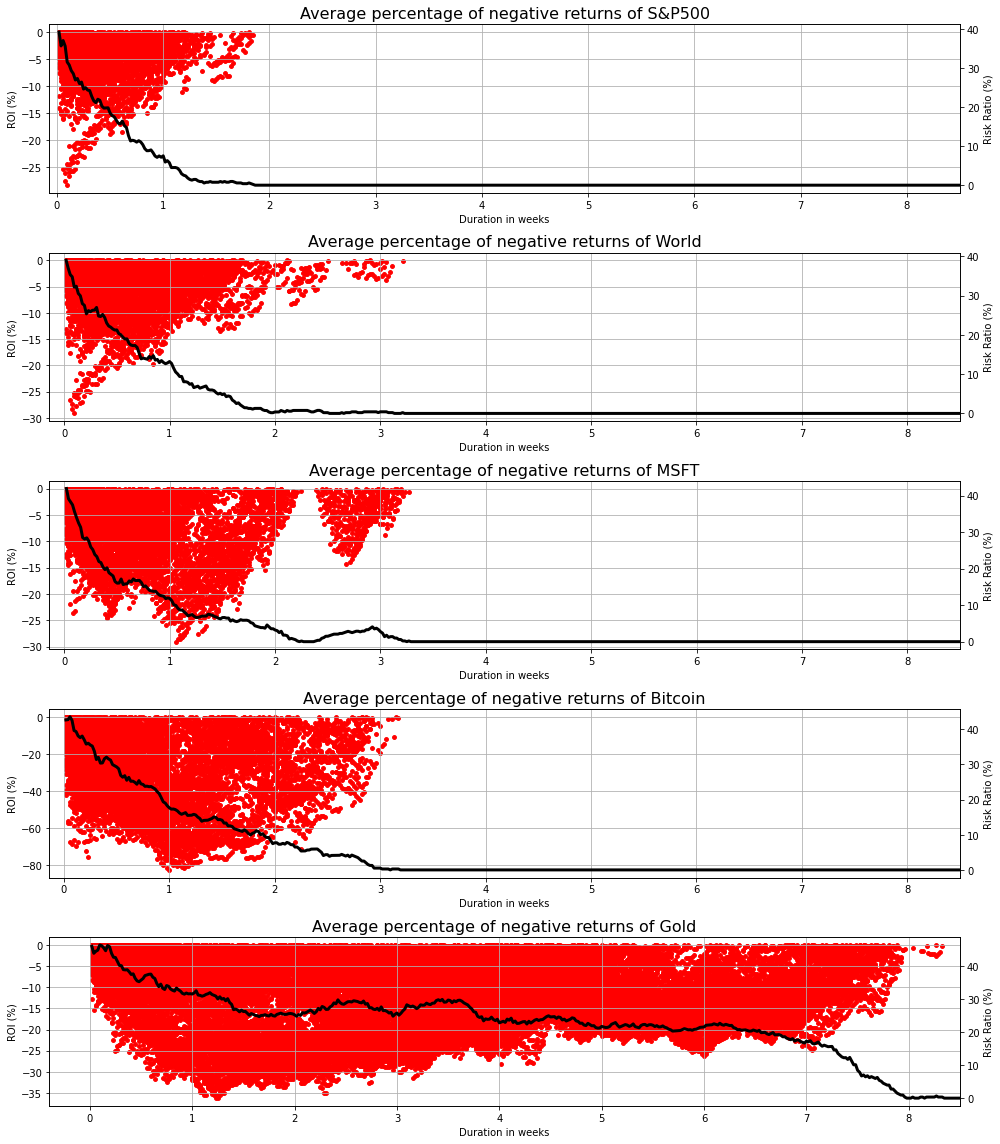

In [12]:
fig, ax = plt.subplots(5, 1, figsize=(14,16), tight_layout=True)

for asset, i in zip(list_assets, range(0,5)):
  ax[i].scatter(df_roi['Duration'][(df_roi['ROI'] <= 0) & (df_roi['Asset']==asset)]/52, df_roi['ROI'][(df_roi['ROI'] <= 0) & (df_roi['Asset']==asset)], c="red", s=15)
  ax[i].set(xlabel = 'Duration in weeks', ylabel='ROI (%)')
  ax[i].set_title('Average percentage of negative returns of ' + str(asset), fontsize = 16)

  ax2=ax[i].twinx()
  ax2.plot(risk_ratio['Duration'][(risk_ratio['Asset']==asset)]/52, risk_ratio['Risk'][(risk_ratio['Asset']==asset)], lw=3, color='black', scalex=False)
  ax[i].set_xlim(right= 8.5)
  ax2.set(ylabel='Risk Ratio (%)')
  ax[i].grid()
# plt.xlim([0,500])
plt.show()

We can conclude therefore that between the 5 assets, historically and in the worst case: 
1.   The S&P500 was the asset with the fastest time to breakeven with 1.8 years or nearly 94 weeks, 
2.   Followed by Bitcoin, MSCI World and Microsoft stock with around 3.2-3.3 years or 166-172 weeks. 
3.   The worst short term performer was Gold with a 8.3 years to breakeven or 432 weeks.

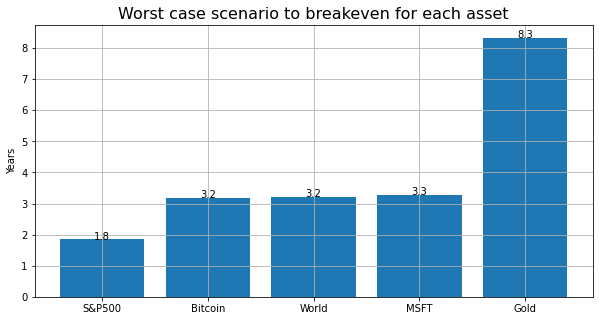

In [13]:
top_duration = df_roi[(df_roi['ROI'] <= 0)].groupby(by=['Asset']).max().sort_values(by='Duration')

fig, ax = plt.subplots(figsize=(10, 5))
plt.bar(x=top_duration.index.tolist(), height=top_duration['Duration']/52)
for i in range(len(top_duration.index.tolist())):
  plt.text(i, top_duration['Duration'][i]/52, round(top_duration['Duration'][i]/52,1), ha = 'center')

plt.title('Worst case scenario to breakeven for each asset', fontsize = 16)
ax.set_ylabel('Years')
plt.grid()
plt.show()

But what if you think the risk is worth and you are a bit more tolerable to it? We can use the risk line to assess how risky holding an asset for a given time is.

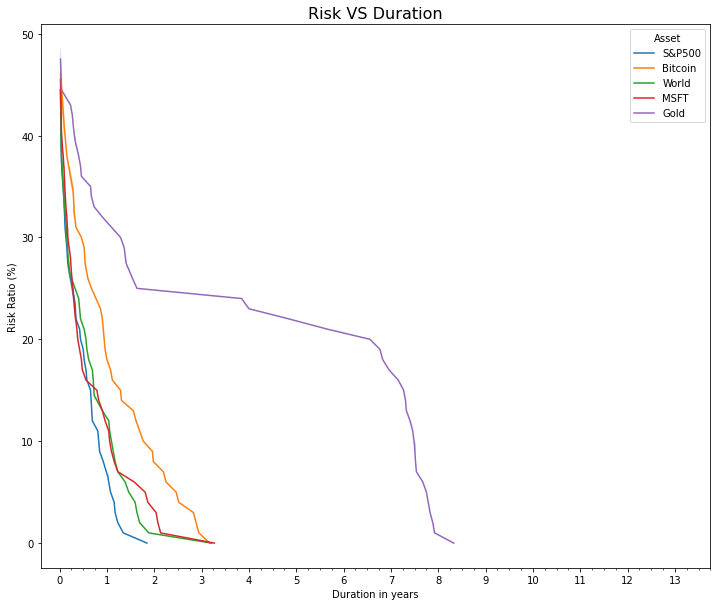

In [14]:
df_risk = top_duration['Duration'].copy().to_frame()
df_risk['Rounded']=([0] * len(df_risk))

for risk in range(1, 50, 1):
  df=risk_ratio[risk_ratio['Risk']<=risk].groupby(by=['Asset']).min()
  df['Rounded']=risk
  df_risk = df_risk.append(df)

df_risk['Duration']=df_risk['Duration']/52  
df_risk.reset_index(inplace=True)

fig, ax = plt.subplots(figsize=(12,10))
sns.lineplot(data=df_risk, x = 'Duration', y = 'Rounded', hue = "Asset")
ax.set(xlabel='Duration in years', ylabel='Risk Ratio (%)')
ax.set_title('Risk VS Duration', fontsize=16)

major_ticks = np.arange(0, 14, 1)
minor_ticks = np.arange(0, 14, 0.25)

ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
ax.grid(which='both')

plt.show()

Some conclusions this chart:


1.   S&P500, MSCI World and Microsoft all have a steep decline on the risk over the first year, from around 45% to 10%.
2.   Bitcoin has a slight higher risk which makes sense being a more volatile asset.
3.   Gold comes as the curve ball, since the risk took 7.5 years to get to 10%. This might be a result from the high devaluation of gold in 2012.

Next we can see a distribution of those negative returns over the different timeframes. Gold has a more linear distribution, while the other assets have the highest frequency of negative returns on the short term. This might be due to the return being susceptible to immediate/short term volatility, growing better with time.

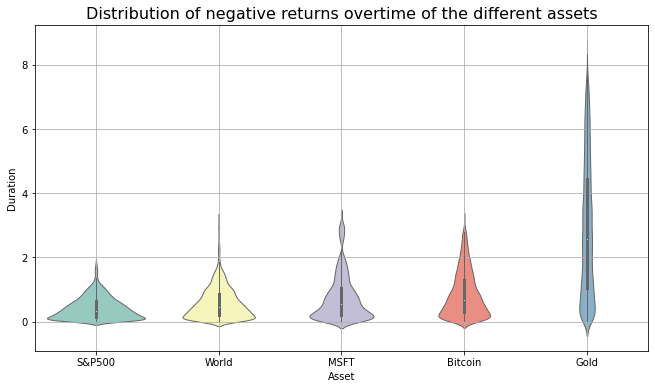

In [15]:
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 6))

# Draw a violinplot with a narrower bandwidth than the default
sns.violinplot(x=df_roi['Asset'][df_roi['ROI'] <= 0], y=df_roi['Duration'][df_roi['ROI'] <= 0]/52, palette="Set3", linewidth=1)
ax.set_title('Distribution of negative returns overtime of the different assets', fontsize=16)
plt.grid()

### **Annualized Return**

One thing that is obvious by now, is that the longer you hold an asset, the higher the return is. But we can turn the return a little bit more "flat" and make it so that the the length of time the investment is held doesn't matter that much. We do this with the Annualized Return given by:

$$
Annualized ROI = [(1+ROI)^\frac{1}{n}-1]*100
$$
where n corresponds to number of years the investment is held.

And why not just dividing the return of investment by the number of years? Because of compounding (every year, you are earning more by accumulating and profiting over that), which over time can make a significant difference. We'll calculate the Annual Return of Investment for all the values in the table and then compare both the normal return and the annualized of the longer investment of the S&P500 to see this effect.

In [16]:
# get annualized return by dividing ROI with the duration
df_roi['Annual ROI'] = (np.power(1+df_roi['ROI']/100,1/(df_roi['Duration']/52))-1)*100

df_roi.head()

,Asset,Date,Duration,ROI,Positive Return,Annual ROI
1,S&P500,2010-05-30,1.0,-0.300772,False,-14.498553
2,S&P500,2010-05-30,2.0,0.536158,True,14.915708
3,S&P500,2010-05-30,3.0,-3.530796,False,-46.370467
4,S&P500,2010-05-30,4.0,-9.833922,False,-73.964774
5,S&P500,2010-05-30,5.0,-5.780044,False,-46.162348


In [17]:
df_roi[df_roi['Asset']=='S&P500'].sort_values(by='Duration', ascending=False).head(1)

,Asset,Date,Duration,ROI,Positive Return,Annual ROI
609,S&P500,2010-05-30,609.0,423.002485,True,15.172839


In [18]:
#Using S&P500 on the 30/05/2010, holding for 609 weeks
#ROI = 423
#Annualized Return = 15.17
period = 609/52

print('Dividing the ROI by the number of years (' + str(round(period,2)) +') would give ' + str(round(423/period,2)) + '%')
print('Initial price was:')
print(76.47)
print('Final price was 399.94')
print('Calculating final price using the averaged annualized return:')
print(76.47*(1+36.12/100)**(period))
print('Calculating final price using the correct annualized return:')
print(76.47*(1+15.17/100)**(period))

Dividing the ROI by the number of years (11.71) would give 36.12%
Initial price was:
76.47
Final price was 399.94
Calculating final price using the averaged annualized return:
2830.8903390200403
Calculating final price using the correct annualized return:
399.8245380193002


On the bit of code above, we can see how much off we would be if we just divided the ROI by the number of years, hence it is important we use the formula aforementioned.

Next, we'll plot the Annualized Return over the different duration of investment and focus on the distribution of the negative values.


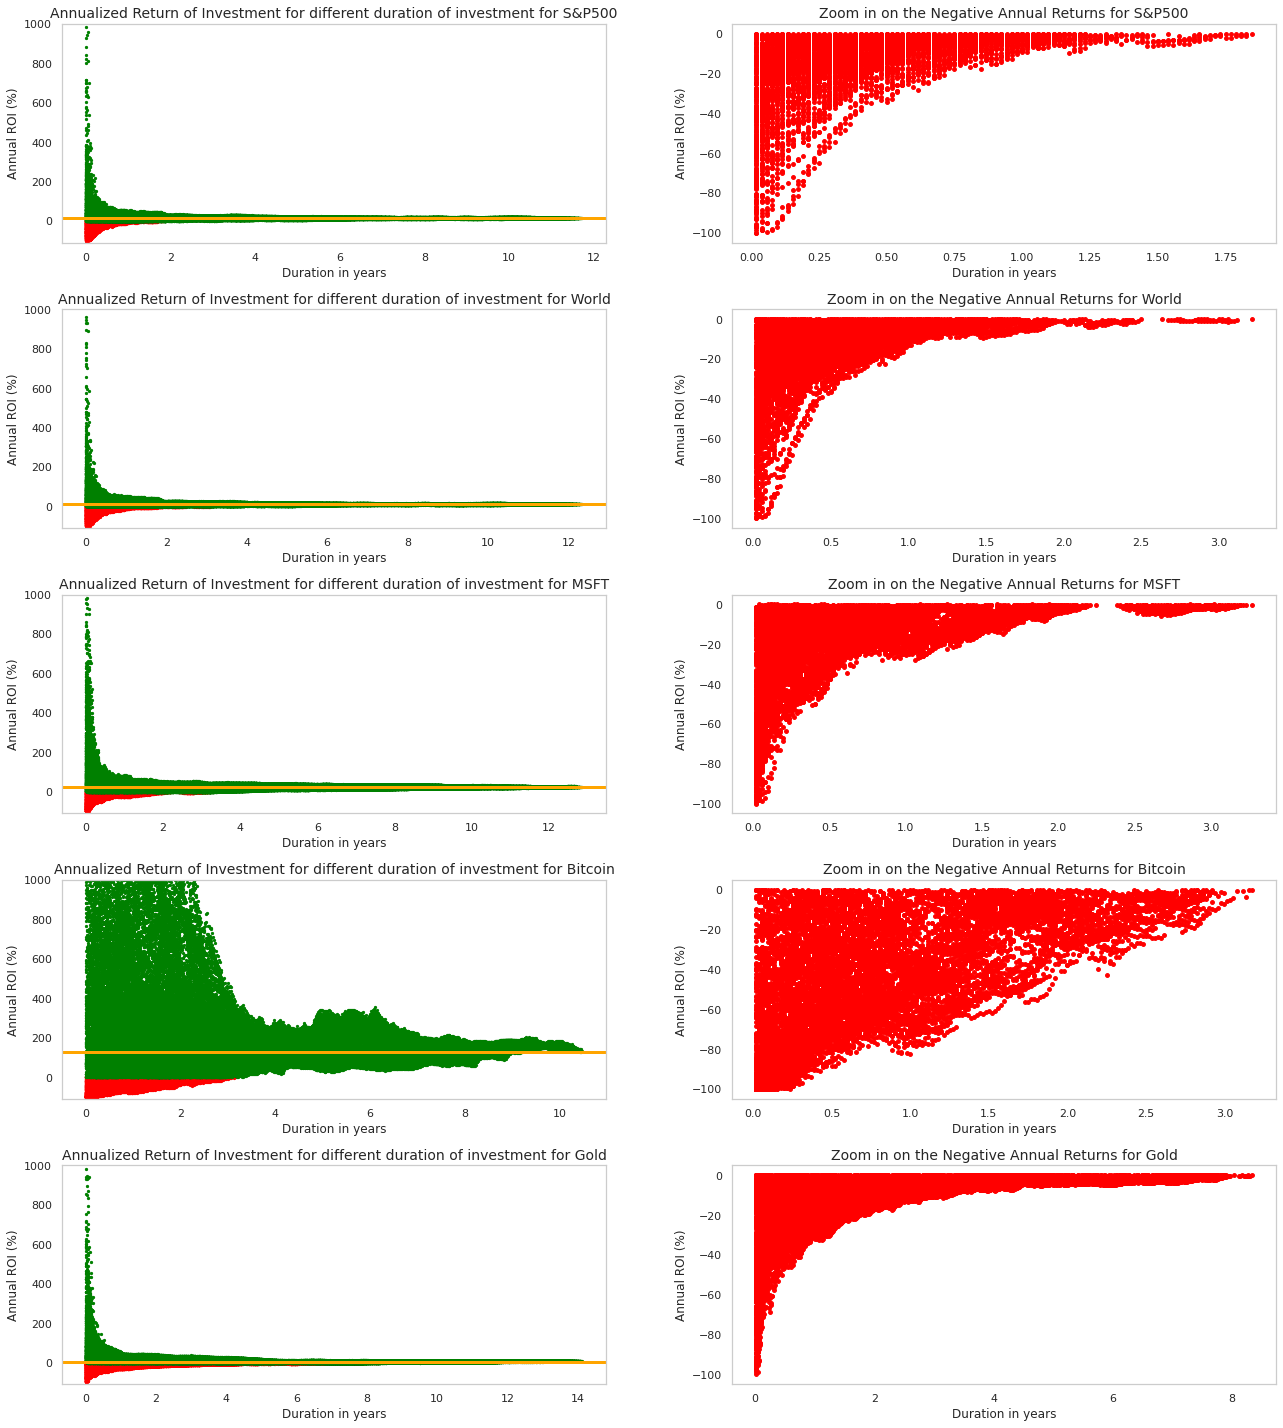

In [37]:
fig, ax = plt.subplots(5, 2, figsize=(18,20), tight_layout=True)

inflation = 0

for asset, i in zip(list_assets, range(0,5)):
  ax[i,0].scatter(df_roi['Duration'][(df_roi['Annual ROI'] <= inflation) & (df_roi['Asset']==asset)]/52, df_roi['Annual ROI'][(df_roi['Annual ROI'] <= inflation) & (df_roi['Asset']==asset)], c="red", s=5)
 
  # plot points outside distribution's width
  ax[i,0].scatter(df_roi['Duration'][(df_roi['Annual ROI'] > inflation) & (df_roi['Asset']==asset)]/52, df_roi['Annual ROI'][(df_roi['Annual ROI'] > inflation) & (df_roi['Asset']==asset)], c="green", s=5)
  ax[i,0].axhline(y=df_roi['Annual ROI'][(df_roi['Asset']==asset)].median(), color='orange', lw=3)

  ax[i,1].scatter(df_roi['Duration'][(df_roi['Annual ROI'] <= inflation) & (df_roi['Asset']==asset)]/52, df_roi['Annual ROI'][(df_roi['Annual ROI'] <= inflation) & (df_roi['Asset']==asset)], c="red", s=15)
  ax[i,0].grid()
  ax[i,1].grid()

  ax[i,0].set(xlabel='Duration in years', ylabel='Annual ROI (%)')
  ax[i,0].set_title('Annualized Return of Investment for different duration of investment for ' + str(asset), fontsize=14)
  ax[i,1].set(xlabel='Duration in years', ylabel='Annual ROI (%)')
  ax[i,1].set_title('Zoom in on the Negative Annual Returns for ' + str(asset), fontsize=14)
  ax[i,0].set_ylim([-110, 1000])

plt.show()

There are some really important conclusions that we can take from these charts.

*   Volatility has higher impact on the shorter timeframes, hence having Annualized Returns of around -100%.
*   Negative returns get a distribution similar to a logarithmic curve, where there is a steep increase on the return followed by a slower growth. The exception is Bitcoin where this seems to be impacted by its volatility.
*   On the longer term, the annualized return of investment is expected to be more and more stable - getting closer to the median.
*   When you shift the mentality of investment to a longer term, the compound starts taking effect, dampening the volatility. Helps even with the higher volatility of Bitcoin, although not as much as the other assets.


Now that we know that long term, the Annualized Return will get closer to the median, we can plot them to check what kind of returns we can expect over the years for these assets.

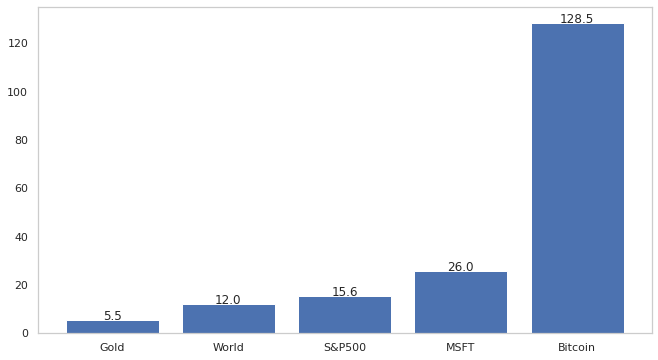

In [60]:
f, ax = plt.subplots(figsize=(11, 6))
median_roi = df_roi.groupby(df_roi['Asset']).median().sort_values(by=['Annual ROI'])
ax.bar(x=median_roi.index.tolist(), height=median_roi['Annual ROI'])

for i in range(len(median_roi.index.tolist())):
  plt.text(i, median_roi['Annual ROI'][i], round(median_roi['Annual ROI'][i],1), ha = 'center')
plt.grid()
plt.show()

So we can easily conclude:


*   Gold was the asset with the lowest annualized return of 5.5%.
*   MSCI World with 12% has a lower return than S&P500 of 15.6%. This is due to the fact that the MSCI World ETF is a broader and more general ETF with less volatility.
*   Same can be said of the Microsoft stock with an annual return of 26%. Being more focused on a company than in several as is the case for the ETFs, the volatily is higher.
*   Bitcoin, the asset with more volatility, is the riskier, but also the most profitable with an 128.5% annual return. You might not expect these returns anymore due to the fact that this asset has become more mature overtime.

Putting this into perspective, an investment of 1000€ on each asset would result in:

**First year:**

*   Gold: 1000*(1+0.055) = 1055€
*   MSCI World: 1000*(1+0.12) = 1120€
*   S&P500: 1000*(1+0.156) = 1156€
*   MSFT: 1000*(1+0.26) = 1260€
*   Bitcoin: 1000*(1+1.285) = 2285€

**Second year:**

*   Gold: 1055*(1+0.055) = 1113€
*   MSCI World: 1120*(1+0.12) = 1254.4€
*   S&P500: 1156*(1+0.156) = 1336.34€
*   MSFT: 1260*(1+0.26) = 1587.6€
*   Bitcoin: 2285*(1+1.285) = 5221.22€


Again, the compounding effect here is clear by applying the same annualized return over an investment that grows every year, which results in higher returns.

### **Inflation**

When investing, your main goal is not only to breakeven. If that was the case, then why bother doing it? At least we want to break inflation so we don't lose buying power due to it. Another advantage of having the annualized return on our data is that now we can compare it against inflation and check how each assets performs.

We'll plot the same charts as before, but now instead of considering negative results everything below or equal to zero, we compare it to different values of inflation - 1, 3, 5 and 7%.

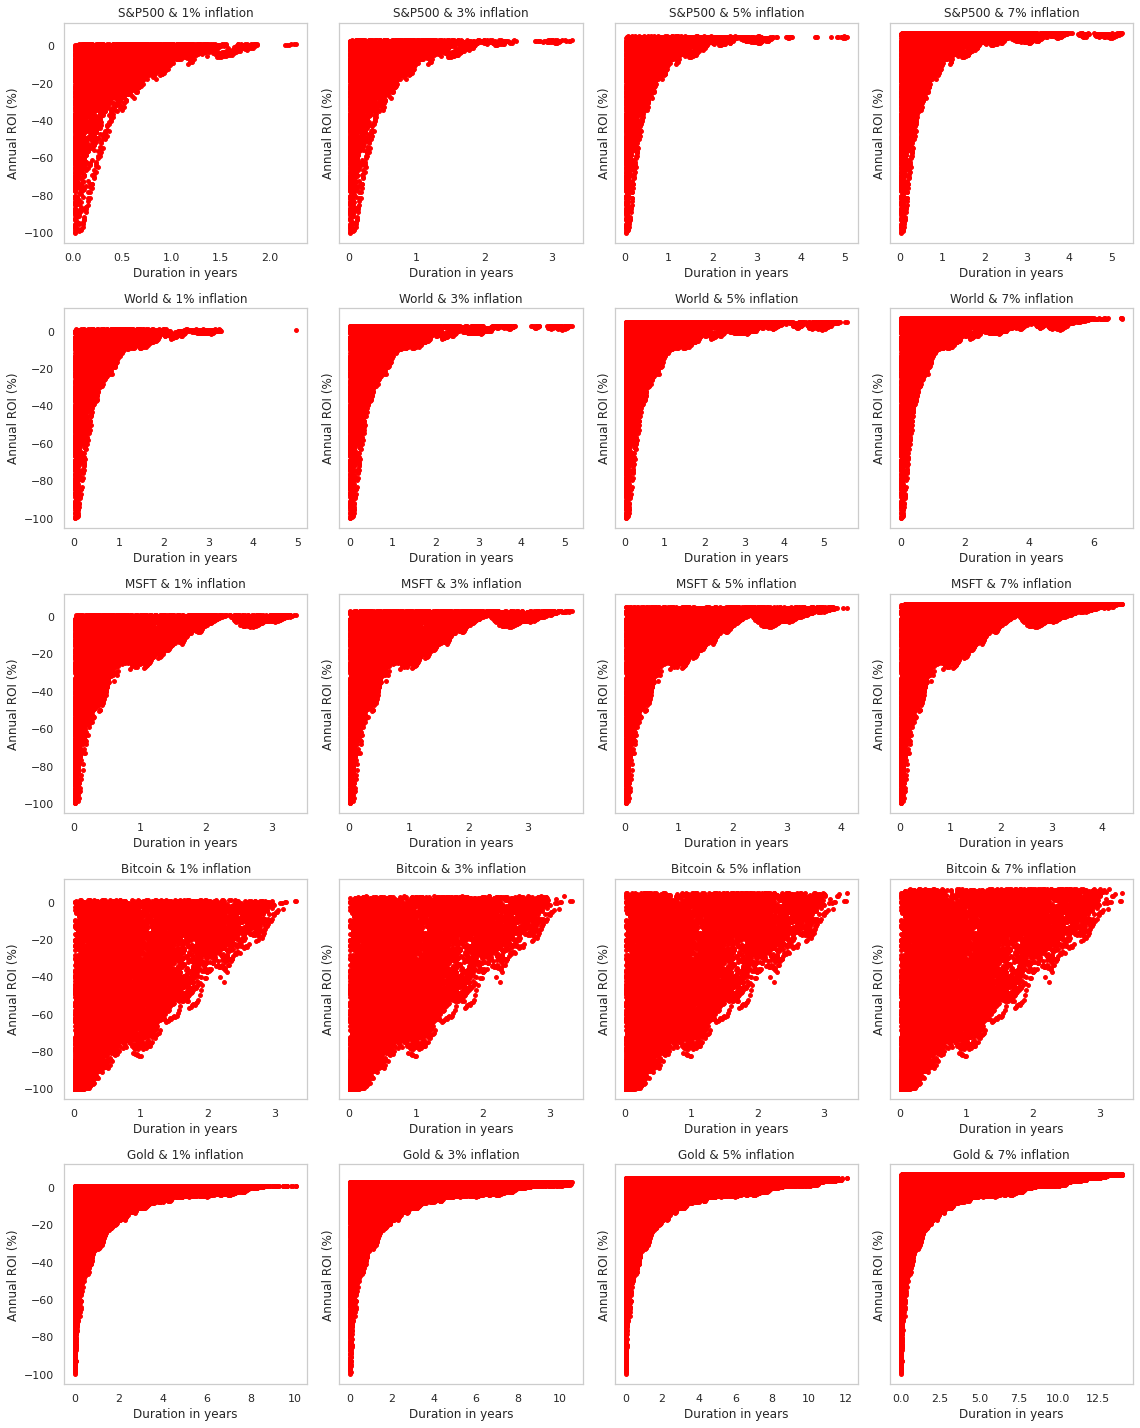

In [178]:
fig, ax = plt.subplots(5, 4, figsize=(16,20), sharey=True, tight_layout=True)

for asset, i in zip(list_assets, range(0,5)):
  for inflation, j in zip([1, 3, 5, 7], range(0,4)):
    ax[i,j].scatter(df_roi['Duration'][(df_roi['Annual ROI'] <= inflation) & (df_roi['Asset']==asset)]/52, df_roi['Annual ROI'][(df_roi['Annual ROI'] <= inflation) & (df_roi['Asset']==asset)], c="red", s=15)
    ax[i,j].set(xlabel='Duration in years', ylabel='Annual ROI (%)', title=str(asset) + ' & ' + str(inflation) + '% inflation')
    ax[i,j].grid()

plt.show()

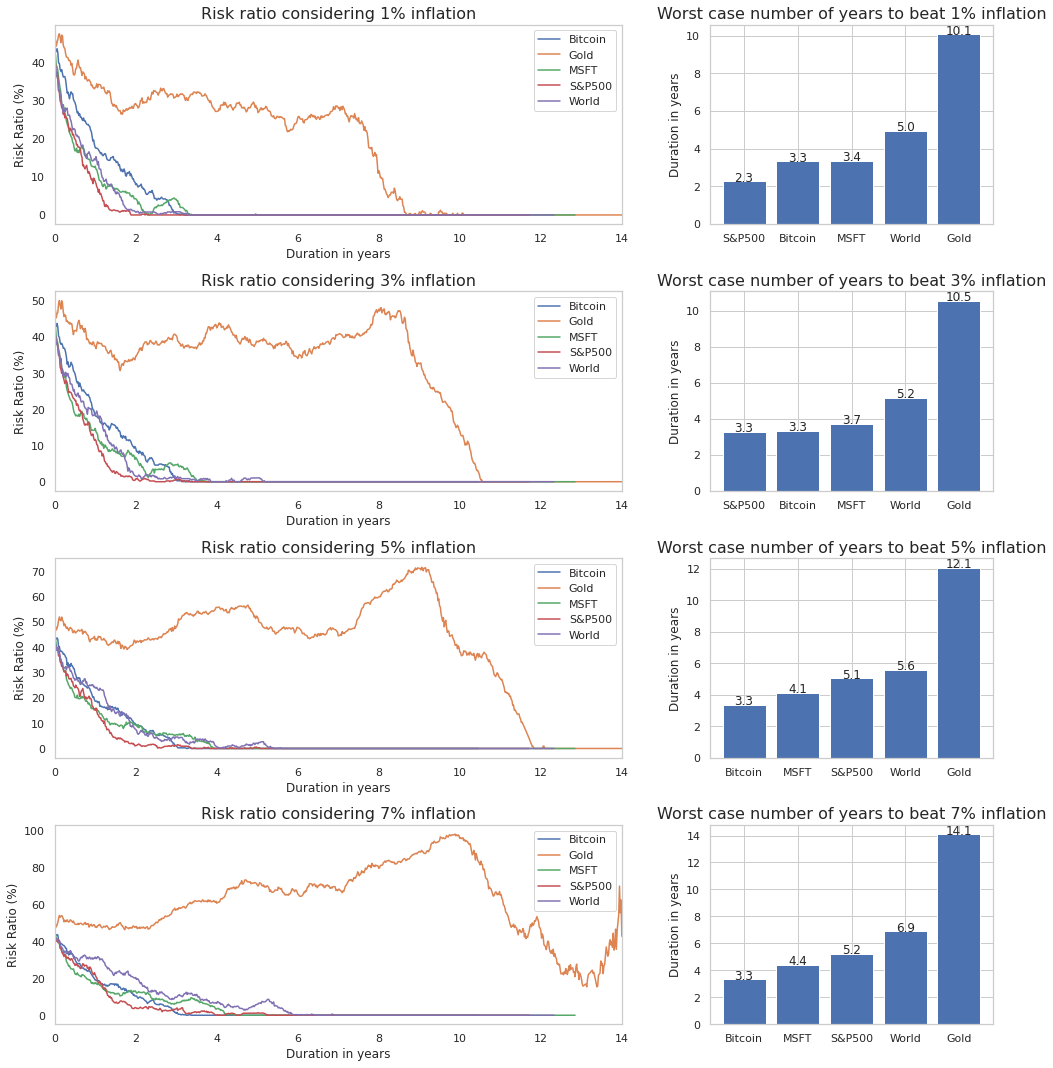

In [176]:
fig, ax = plt.subplots(4, 2, figsize=(15,15), tight_layout=True, gridspec_kw={'width_ratios': [2, 1]})

inf_mean = df_roi[['Asset', 'Duration', 'Annual ROI']].copy()
inf_mean['Duration'] = inf_mean['Duration']/52

# Set inflation to 0%
inflation = 0

top_duration = df_roi[(df_roi['Annual ROI'] <= inflation)].groupby(by=['Asset']).max().sort_values(by='Duration')
top_duration['Inflation'] = inflation
df_topdur_inf = top_duration[['Duration', 'Inflation']].copy()
inflation = 1
#Loop through the different inflation values (1,2,3 and 5) and plot
for i in range(0,4):

  inf_mean['Boolean Inf ' + str(inflation)] = inf_mean['Annual ROI'] - inflation > 0
  sns.lineplot(data=(1-inf_mean.groupby(by=['Asset', 'Duration']).mean())*100, x = 'Duration', y = 'Boolean Inf ' + str(inflation), hue = "Asset", ax=ax[i,0])
  ax[i,0].set(xlabel='Duration in years', ylabel='Risk Ratio (%)')
  ax[i,0].set_title('Risk ratio considering '+ str(inflation) + '% inflation', fontsize=16)
  ax[i,0].set_xlim([0, 14])
  ax[i,0].grid()
  ax[i,0].legend(loc="upper right")

  top_duration = df_roi[(df_roi['Annual ROI'] <= inflation)].groupby(by=['Asset']).max().sort_values(by='Duration')
  top_duration['Inflation']=inflation
  df_topdur_inf = df_topdur_inf.append(top_duration[['Duration', 'Inflation']])

  ax[i,1].bar(x=top_duration.index.tolist(), height=top_duration['Duration']/52)
  ax[i,1].set(ylabel='Duration in years')
  ax[i,1].set_title('Worst case number of years to beat '+ str(inflation) + '% inflation', fontsize=16)
  inflation += 2
  for j in range(len(top_duration.index.tolist())):
    ax[i,1].text(j, top_duration['Duration'][j]/52, round(top_duration['Duration'][j]/52,1), ha = 'center')

plt.show()

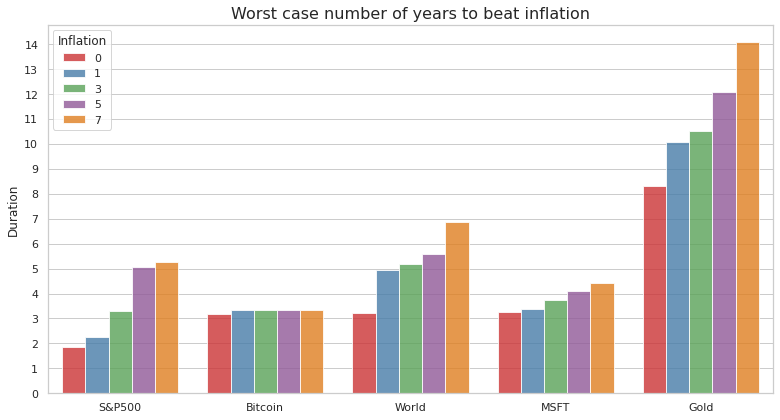

In [155]:
f, ax = plt.subplots(figsize=(11, 6), tight_layout=True)

sns.barplot(data=df_topdur_inf,
            x=df_topdur_inf.index.tolist(), y=df_topdur_inf['Duration']/52, hue="Inflation", 
            palette='Set1', alpha=0.8, ax=ax)

major_ticks = np.arange(0, 15, 1)
ax.set_yticks(major_ticks)
# plt.grid()
ax.set_title('Worst case number of years to beat inflation', fontsize=16)

plt.show()

It comes to no surprise that the higher the inflation to be beat, the longer is duration for the investment to be held in order to secure an annualized return higher than the inflation itself.

The scenario depicted here is for the worst case possible.

You can see that Bitcoin and Microsoft are the assets that best beat the inflation with little difference to the breakeven duration (between 3 to roughly 4 years), even surpassing the performance of S&P500 with an inflation of 5%.

S&P500 and MSCI World had a jump of 3-4 years from the breakeven duration.

Gold continues to be the worst asset with the highest duration in any of the categories, from 8 to 12 years, not being able to beat an inflation of 7%.

The risk for all assets except Gold decreases relatively quickly and gets under the 10% in less than 3 years, while Gold has a different risk, more unpredictable behaviour.

These charts tell us that in order to consistently beat an inflation of 7% every year, you would have to hold Bitcoin for a little more than 3 years, Microsoft for 4 years, S&P500 for more than 5 years, MSCI World for almost 7 and Gold, with today's data, beats it with around 40% risk.

This makes sense if we remember what we learned about the annualized returns of each asset where it tends to approximate the median. An inflation of 7% is higher than the median, so you are taking risk trying to beat it with Gold. In the next charts, we take a look at the distribution of the annualized returns of holding periods of 3 and 6 years. You'll see the outliers (the dots) lessening with the holding period and that the 25 and 75% percentiles don't change, the whiskers do. As seen before, with time, the annualized return for each asset will approximate to the center line - the median - getting inside the boxes, decreasing the risk of negative return for inflations underneath. For example, the 3, 5 and 7% inflation are inside the box of Gold, hence the riskier is to beat this kind of inflations, as seen.

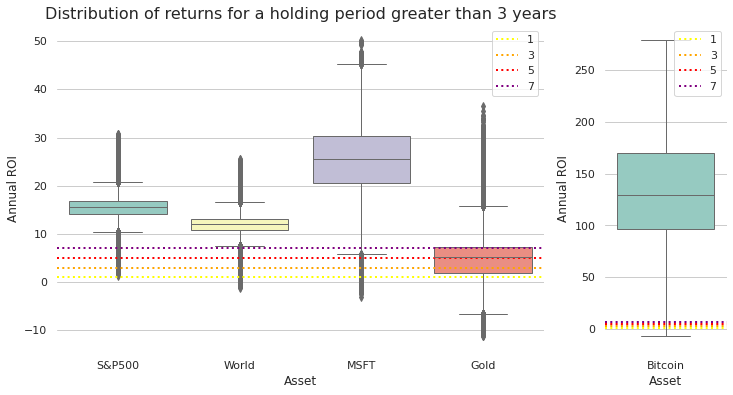

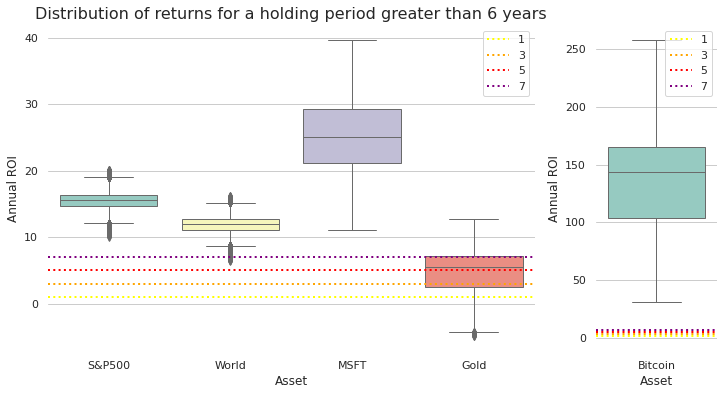

In [184]:
sns.set_theme(style="whitegrid")
# Set up the matplotlib figure
f1, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), gridspec_kw={'width_ratios': [4, 1]})
df_saferoi = df_roi[df_roi['Duration']>=52*3]

# Draw a violinplot with a narrower bandwidth than the default
sns.boxplot(x=df_saferoi['Asset'][df_saferoi['Asset'] != 'Bitcoin'], y=df_saferoi['Annual ROI'][df_saferoi['Asset'] != 'Bitcoin'], palette="Set3", linewidth=1, showfliers=True, ax=ax1)
sns.boxplot(x=df_saferoi['Asset'][df_saferoi['Asset'] == 'Bitcoin'], y=df_saferoi['Annual ROI'][df_saferoi['Asset'] == 'Bitcoin'], palette="Set3", linewidth=1, showfliers=False, ax=ax2)

ax1.set_title('Distribution of returns for a holding period greater than 3 years', fontsize=16)
# Finalize the figure
sns.despine(left=True, bottom=True)
for ax in [ax1, ax2]:
  ax.axhline(1, color='yellow', ls=':', lw=2, label = '1')
  ax.axhline(3, color='orange', ls=':', lw=2, label = '3')
  ax.axhline(5, color='red', ls=':', lw=2, label = '5')
  ax.axhline(7, color='purple', ls=':', lw=2, label = '7')
  ax.legend(loc='upper right')

f2, (ax3, ax4) = plt.subplots(1, 2, figsize=(12, 6), gridspec_kw={'width_ratios': [4, 1]})
df_saferoi = df_roi[df_roi['Duration']>=52*6]

# Draw a violinplot with a narrower bandwidth than the default
sns.boxplot(x=df_saferoi['Asset'][df_saferoi['Asset'] != 'Bitcoin'], y=df_saferoi['Annual ROI'][df_saferoi['Asset'] != 'Bitcoin'], palette="Set3", linewidth=1, showfliers=True, ax=ax3)
sns.boxplot(x=df_saferoi['Asset'][df_saferoi['Asset'] == 'Bitcoin'], y=df_saferoi['Annual ROI'][df_saferoi['Asset'] == 'Bitcoin'], palette="Set3", linewidth=1, showfliers=False, ax=ax4)

ax3.set_title('Distribution of returns for a holding period greater than 6 years', fontsize=16)

# Finalize the figure
sns.despine(left=True, bottom=True)
for ax in [ax3, ax4]:
  ax.axhline(1, color='yellow', ls=':', lw=2, label = '1')
  ax.axhline(3, color='orange', ls=':', lw=2, label = '3')
  ax.axhline(5, color='red', ls=':', lw=2, label = '5')
  ax.axhline(7, color='purple', ls=':', lw=2, label = '7')
  ax.legend(loc='upper right')

plt.show()

### **Is it possible to find a good opportunity?**

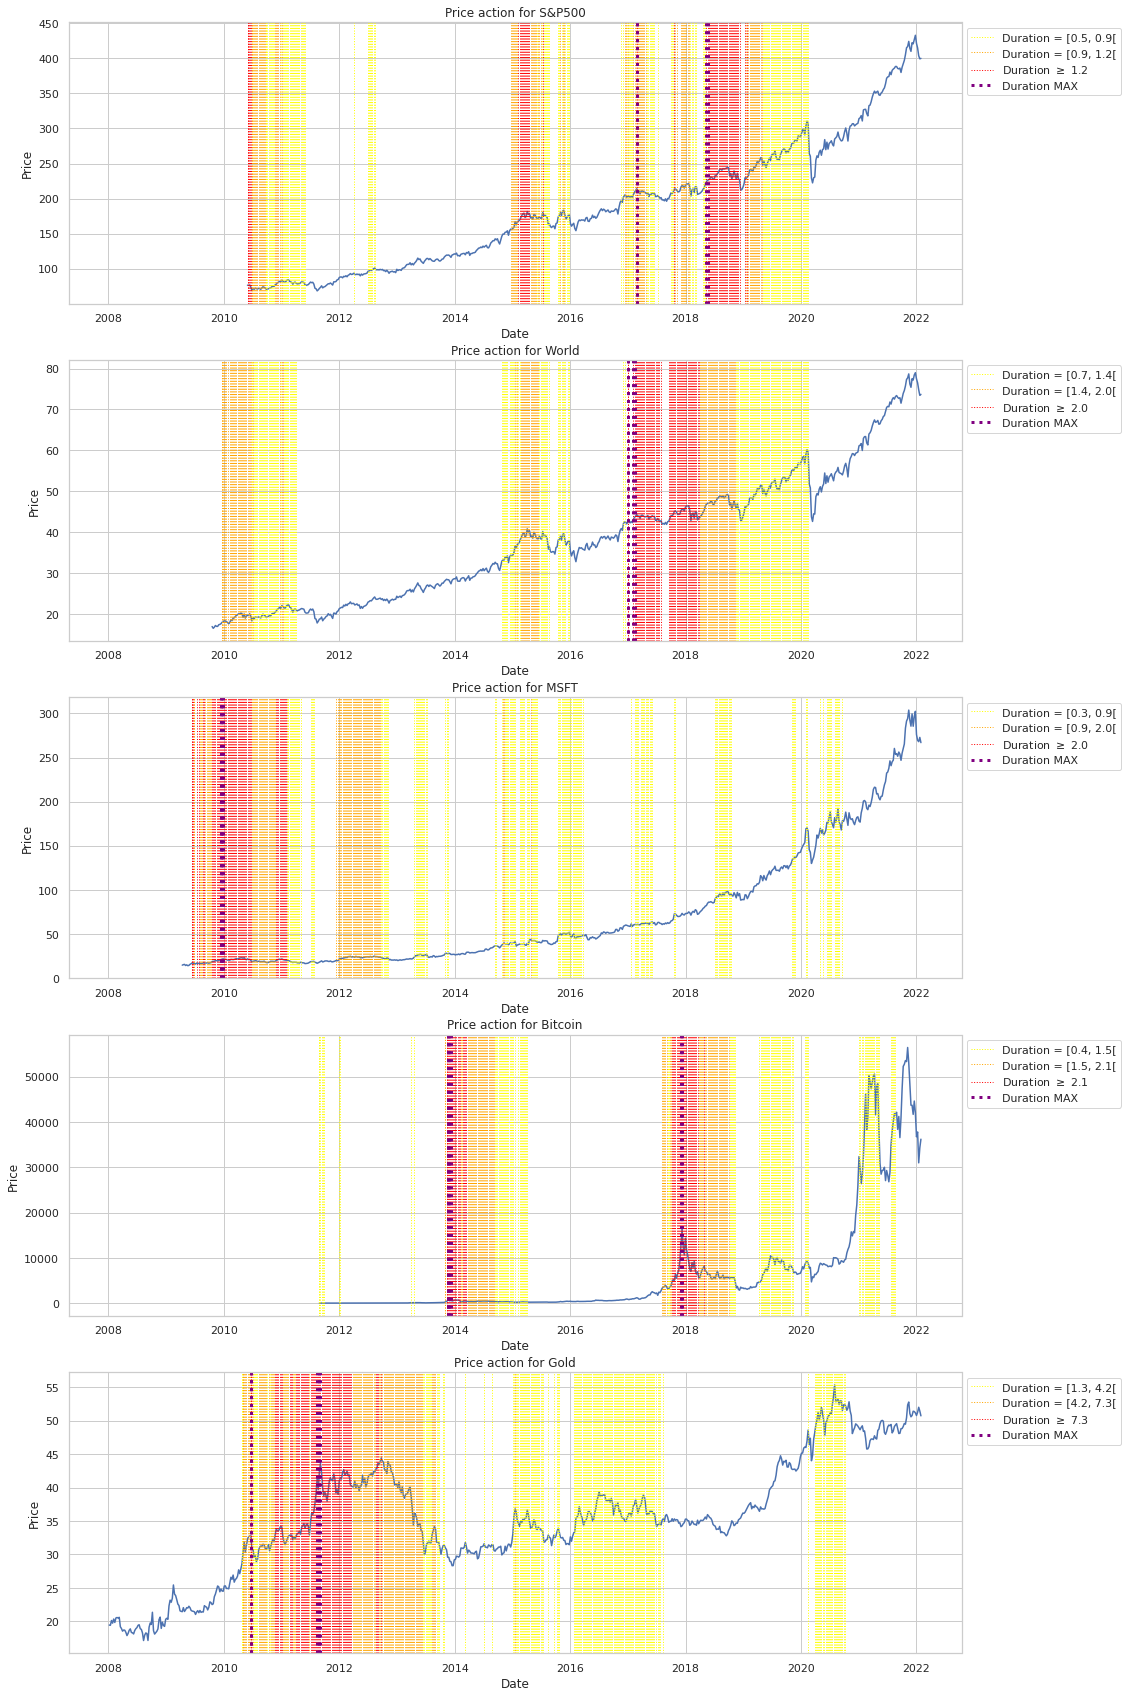

In [24]:
df_wperf = df_roi[(df_roi['ROI'] <= 0)].groupby(by=['Asset', 'Date'])['Duration'].max()

fig, ax = plt.subplots(5,1,figsize=(16,30), sharex=True)

for i, asset in zip(range(0,5), list_assets):

  ax[i].plot(df_main.loc[asset]['Date'], df_main.loc[asset]['Price'])
  ax[i].set(xlabel='Date', ylabel='Price', title='Price action for ' + asset)

  str_median = str(round(df_wperf.loc[asset].median()/52,1))
  str_quant75 = str(round(df_wperf.loc[asset].quantile(.75)/52,1))
  str_quant90 = str(round(df_wperf.loc[asset].quantile(.9)/52,1))

  wdates = df_wperf.loc[asset][(df_wperf.loc[asset] >= df_wperf.loc[asset].median()) & (df_wperf.loc[asset] < df_wperf.loc[asset].quantile(.75))]

  xcoords = wdates.index.tolist()
  ax[i].axvline(x=xcoords[0], color='yellow', ls=':', lw=1, label = 'Duration = [' + str_median + ', ' + str_quant75 + '[')

  for xc in xcoords:
      ax[i].axvline(x=xc, color='yellow', ls=':', lw=1)

  wdates = df_wperf.loc[asset][(df_wperf.loc[asset] >= df_wperf.loc[asset].quantile(.75)) & (df_wperf.loc[asset] < df_wperf.loc[asset].quantile(.9))]

  xcoords = wdates.index.tolist()
  ax[i].axvline(x=xcoords[0], color='orange', ls=':', lw=1, label = 'Duration = [' + str_quant75 + ', ' + str_quant90 + '[')

  for xc in xcoords:
      ax[i].axvline(x=xc, color='orange', ls=':', lw=1)

  wdates = df_wperf.loc[asset][df_wperf.loc[asset] >= df_wperf.loc[asset].quantile(.9)]

  xcoords = wdates.index.tolist()
  ax[i].axvline(x=xcoords[0], color='red', ls=':', lw=1, label = r'Duration $\geq$ ' + str_quant90)

  for xc in xcoords:
      ax[i].axvline(x=xc, color='red', ls=':', lw=1)

  wdates = df_wperf.loc[asset][df_wperf.loc[asset] >= df_wperf.loc[asset].quantile(0.995)]

  xcoords = wdates.index.tolist()
  ax[i].axvline(x=xcoords[0], color='purple', ls=':', lw=3, label = r'Duration MAX')

  for xc in xcoords:
      ax[i].axvline(x=xc, color='purple', ls=':', lw=3)

  ax[i].xaxis.set_tick_params(labelbottom=True)
  ax[i].legend(bbox_to_anchor=(1.0, 1), loc='upper left')

plt.show()

114
104
157
135
91


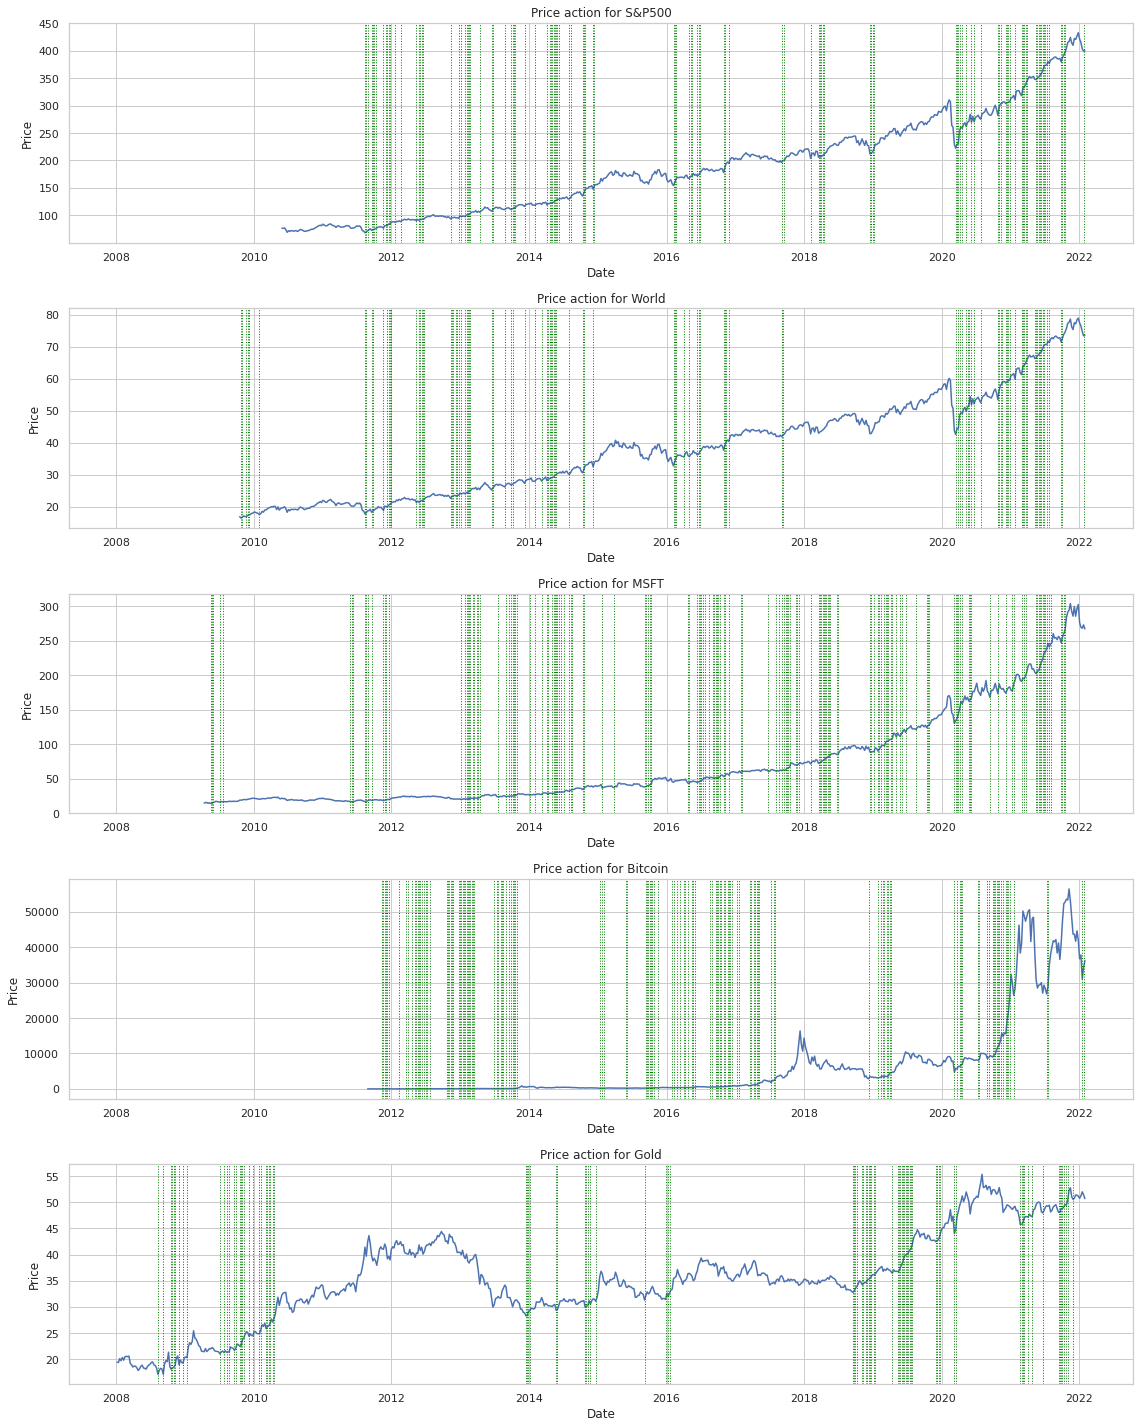

In [225]:
fig, ax = plt.subplots(5, 1, figsize=(16,20), sharex=True, tight_layout=True)

for i, asset in zip(range(0,5), list_assets):
  dates_to_drop = df_roi['Date'][(df_roi['ROI'] <= 0) & (df_roi['Asset']==asset)].tolist()
  bdates = df_roi[(~df_roi['Date'].isin(dates_to_drop)) & (df_roi['Asset'] == asset)].groupby(by='Date')['Duration'].max()
  
  ax[i].plot(df_main.loc[asset]['Date'], df_main.loc[asset]['Price'])
  ax[i].set(xlabel='Date', ylabel='Price', title='Price action for ' + asset)
  ax[i].xaxis.set_tick_params(labelbottom=True)

  xcoords = bdates.index.tolist()
  for xc in xcoords:
    ax[i].axvline(x=xc, color='green', ls=':', lw=1)

plt.show()

495
537
511
409
643


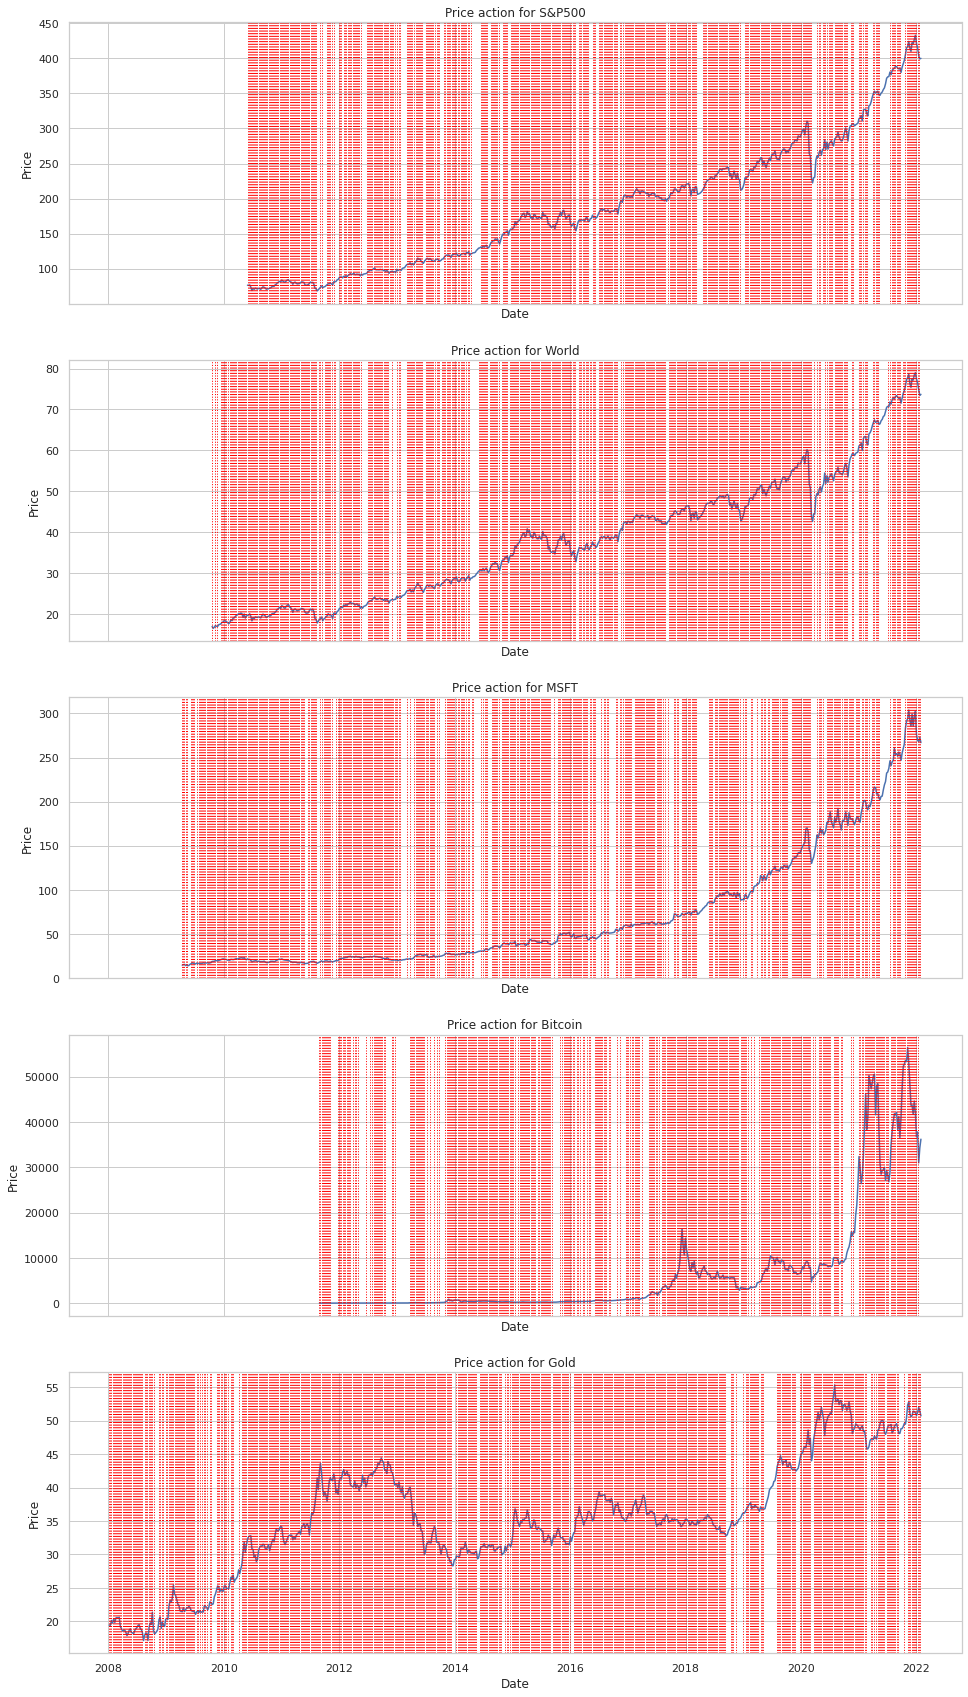

In [229]:
df_wperf = df_roi[(df_roi['ROI'] <= 0)].groupby(by=['Asset', 'Date'])['Duration'].max()

fig, ax = plt.subplots(5,1,figsize=(16,30), sharex=True)

for i, asset in zip(range(0,5), list_assets):

  ax[i].plot(df_main.loc[asset]['Date'], df_main.loc[asset]['Price'])
  ax[i].set(xlabel='Date', ylabel='Price', title='Price action for ' + asset)

  wdates = df_wperf.loc[asset]
  xcoords = wdates.index.tolist()
  for xc in xcoords:
      ax[i].axvline(x=xc, color='red', ls=':', lw=1)

plt.show()

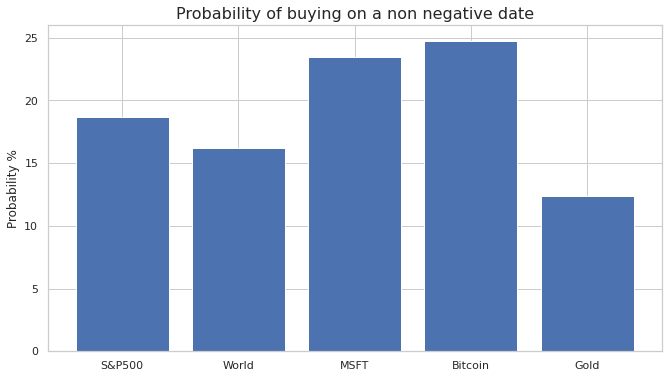

In [234]:
pdays=[]
for asset in list_assets:
  dates_to_drop = df_roi['Date'][(df_roi['ROI'] <= 0) & (df_roi['Asset']==asset)].tolist()
  bdates = df_roi[(~df_roi['Date'].isin(dates_to_drop)) & (df_roi['Asset'] == asset)].groupby(by='Date')['Duration'].max()
  totdates = df_main[(df_main['Asset'] == asset)]['Date'].count()
  pdays.append(bdates.count()/totdates*100)

f, ax = plt.subplots(figsize=(11, 6))
plt.bar(x=list_assets, height=pdays)
plt.ylabel('Probability %')
plt.title('Probability of buying on a non negative date', fontsize=16)
plt.show()

In [333]:
df_corr=df_roi.merge(df_main, how='left', on=['Date','Asset'])
df_corr.head()

,Asset,Date,Duration,ROI,Positive Return,Annual ROI,Price,Open,High,Low,Vol.,Change %
0,S&P500,2010-05-30,1.0,-0.300772,False,-14.498553,76.47,75.76,77.44,75.49,260,1.49
1,S&P500,2010-05-30,2.0,0.536158,True,14.915708,76.47,75.76,77.44,75.49,260,1.49
2,S&P500,2010-05-30,3.0,-3.530796,False,-46.370467,76.47,75.76,77.44,75.49,260,1.49
3,S&P500,2010-05-30,4.0,-9.833922,False,-73.964774,76.47,75.76,77.44,75.49,260,1.49
4,S&P500,2010-05-30,5.0,-5.780044,False,-46.162348,76.47,75.76,77.44,75.49,260,1.49


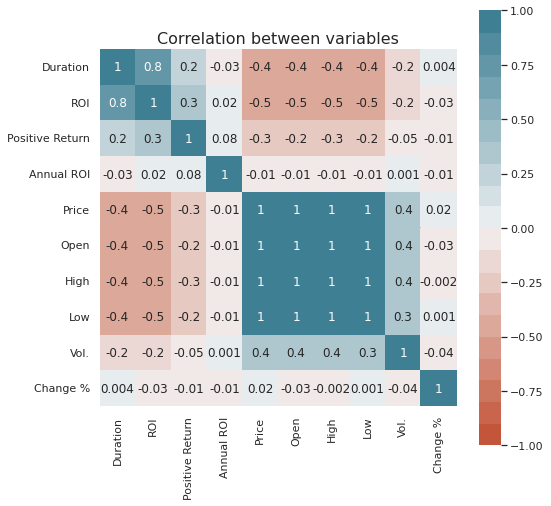

In [344]:
for asset, i in zip(list_assets, range(0,5)):
  df_temp=df_roi[df_roi['Asset']==asset].merge(df_main, how='left', on=['Date','Asset']).copy()
  for list_columns in ['ROI', 'Annual ROI', 'Price', 'Open', 'High', 'Low', 'Vol.', 'Change %']:
  #applying standardization
    df_temp[list_columns] = (df_temp[list_columns]-df_temp[list_columns].mean())/df_temp[list_columns].std()
  if i==0:
    df_corr=df_temp
  else:
    df_corr=pd.concat([df_corr, df_temp])

corr=df_corr.corr()

f, ax = plt.subplots(figsize=(8, 8))
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=20),
    square=True, annot=True, fmt=".1g"
)
ax.set_title('Correlation between variables', fontsize=16)
plt.show()

In [331]:
df_corr.corr()

,Duration,ROI,Positive Return,Annual ROI,Price,Open,High,Low,Vol.,Change %
Duration,1.000000,0.764285,0.226970,-0.026715,-0.406792,-0.406680,-0.405754,-0.408284,-0.171963,0.004427
ROI,0.764285,1.000000,0.298329,0.015313,-0.452162,-0.450751,-0.451585,-0.451353,-0.171963,-0.025623
Positive Return,0.226970,0.298329,1.000000,0.082187,-0.250389,-0.249039,-0.251455,-0.247450,-0.050146,-0.012579
Annual ROI,-0.026715,0.015313,0.082187,1.000000,-0.014889,-0.014359,-0.014182,-0.014984,0.001166,-0.011525
Price,-0.406792,-0.452162,-0.250389,-0.014889,1.000000,0.996737,0.998649,0.998535,0.354621,0.024862
Open,-0.406680,-0.450751,-0.249039,-0.014359,0.996737,1.000000,0.998542,0.997988,0.356399,-0.028642
High,-0.405754,-0.451585,-0.251455,-0.014182,0.998649,0.998542,1.000000,0.997787,0.368245,-0.002176
Low,-0.408284,-0.451353,-0.247450,-0.014984,0.998535,0.997988,0.997787,1.000000,0.341639,0.001117
Vol.,-0.171963,-0.171963,-0.050146,0.001166,0.354621,0.356399,0.368245,0.341639,1.000000,-0.038004
Change %,0.004427,-0.025623,-0.012579,-0.011525,0.024862,-0.028642,-0.002176,0.001117,-0.038004,1.000000


# **Conclusions**

# Archive

In [187]:
# bdates = df_roi[(~df_roi['Date'].isin(dates_to_drop))].groupby(by=['Asset', 'Date']).max()
# bdates.sort_values(by=['Annual ROI'], ascending=False)

Duration           ROI  Positive Return    Annual ROI
Asset   Date                                                             
Bitcoin 2020-03-08      99.0   1103.585131             True  7.185068e+06
        2018-12-09     164.0   1879.020783             True  6.466795e+06
        2021-02-28      48.0     37.661236             True  3.740302e+06
        2019-06-09     138.0    614.931061             True  6.923453e+05
        2013-12-22     423.0  10211.796932             True  6.134597e+05
...                      ...           ...              ...           ...
S&P500  2015-12-27     318.0    145.038773             True  1.779414e+01
World   2018-09-30     174.0     61.447261             True  1.636928e+01
        2018-09-23     175.0     60.463226             True  1.603661e+01
        2010-04-18     615.0    290.410282             True  1.513592e+01
        2015-12-27     318.0    108.335532             True  1.422268e+01

[373 rows x 4 columns]

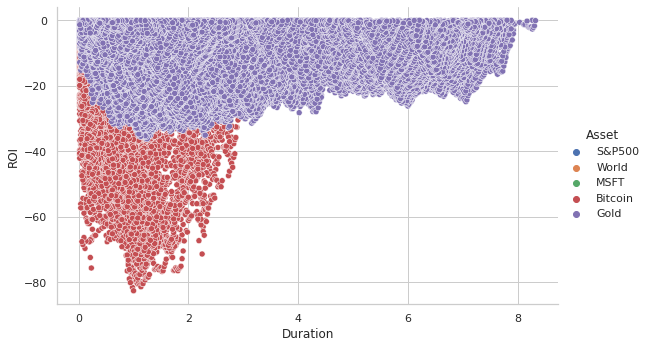

In [27]:
sns.relplot(x=df_roi['Duration'][(df_roi['ROI'] <= 0)]/52, y=df_roi['ROI'][(df_roi['ROI'] <= 0)], hue=df_roi['Asset'][(df_roi['ROI'] <= 0)], aspect=1.61)
plt.show()

In [28]:
sns.set_theme(style="whitegrid")
ax = [ax1, ax2, ax3, ax4, ax5]
# Set up the matplotlib figure
f, ax = plt.subplots(5, 1, figsize=(12, 12))
duration = {0.25*52 ,0.5*52, 0.75*52,1*52,2*52, 3*52, 4*52, 5*52}

# Draw a violinplot with a narrower bandwidth than the default

for ax, asset in zip(ax, list_assets):
  sns.violinplot(x=df_roi['Duration'][(df_roi['Duration'].isin(duration)) & (df_roi['Asset']==asset)]/52, y=df_roi['ROI'][(df_roi['Duration'].isin(duration)) & (df_roi['Asset']==asset)], cut=0, scale='width', palette="Set3", bw=.2, linewidth=1, ax=ax)
  ax.axhline(0, c='red')
  ax.set_title(str(asset), fontsize=16)
  # ax.set_ylim(-10,None)

# ax.set_title('Distribution of negative returns in the different assets', fontsize=16)
# Finalize the figure
plt.tight_layout()
sns.despine(left=True, bottom=True)
plt.show()

NameError: ignored

In [ ]:
# sns.relplot(x=df_test['Change %'], y=df_test['Vol.'], hue=df_test['ROI'])
df_test.plot.scatter('Vol.', 'ROI')

plt.show()

In [ ]:
df_roi[(df_roi['ROI'] < 0) & (df_roi['Asset']=='S&P500')].groupby(by=['Asset', 'Date'])['Duration'].min().sort_values(ascending=False).head(10)

In [ ]:
df_roi[(df_roi['ROI'] < 0)].groupby(by=['Asset', 'Date'])['Duration'].max().sort_values(ascending=False).head(135)

In [182]:
# lowest breakeven duration or non-existant
#df_roi[(df_roi['ROI'] < 0)].sort_values(by=['Duration'], ascending=True).head(5)

# largest breakeven duration

df_roi[df_roi['Asset']=='Gold'].sort_values(by=['Duration'], ascending=False).head(5)

,Asset,Date,Duration,ROI,Positive Return,Annual ROI
734,Gold,2008-01-06,734.0,160.719794,True,7.024626
734,Gold,2008-01-13,733.0,161.122554,True,7.046260
733,Gold,2008-01-06,733.0,164.370180,True,7.140166
734,Gold,2008-01-20,732.0,151.912568,True,6.783484
732,Gold,2008-01-06,732.0,167.300771,True,7.234208


In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2)
#ax1.plot()

ax1.plot(df_sp['Date'][421:600], df_sp['Price'][421:600])

ax1.set(xlabel='Date', ylabel='Price',
       title='Price action for S&P 500 ETF')
ax1.plot(df_sp['Date'][421], df_sp['Price'][421], 'ro')
ax1.grid()

ax2.plot(df_roi['Duration'][0:50]/4/12, df_roi['ROI'][0:50]-2)
ax2.grid()
plt.show()
